## Score function

In [1]:
from tsfresh.examples import load_robot_execution_failures
import pandas as pd
import tsfresh
import matplotlib.pyplot as plt

from sklearn import neighbors, svm, metrics
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from tqdm import tqdm

from utils.help_classes import ModelsEnum
from sklearn.model_selection import train_test_split
import os
import datetime

import pickle
import numpy as np
import category_encoders as ce
import plotly_express as px
from sklearn.decomposition import PCA

from numpy.linalg import LinAlgError

In [15]:
def min_acc(y_true, y_pred):
    y_true_0 = y_true[y_true == 0]
    y_pred_0 = y_pred[y_true == 0]
    
    y_true_1 = y_true[y_true == 1]
    y_pred_1 = y_pred[y_true == 1]
    
    y_true_2 = y_true[y_true == 2]
    y_pred_2 = y_pred[y_true == 2]
    
    acc_0 = metrics.accuracy_score(y_true_0, y_pred_0)
    acc_1 = metrics.accuracy_score(y_true_1, y_pred_1)
    acc_2 = metrics.accuracy_score(y_true_2, y_pred_2)
    
    return min(acc_0, acc_1, acc_2)

In [9]:
y_true = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
y_pred = np.array([1, 2, 1, 1, 1, 1, 2, 1, 2])

In [16]:
min_acc(y_true, y_pred)

0.0

## Split data

In [3]:
X = pd.read_csv(os.path.join('data_csv', 'train_all.csv'))
print('X', X.shape)

X['time_stamp'] = pd.to_datetime(X['time_stamp'])
X_train = X.loc[X['time_stamp'] < X['time_stamp'].quantile(q=0.8)]
X_val = X.loc[X['time_stamp'] >= X['time_stamp'].quantile(q=0.8)]

print('X_train', X_train.shape)
print('X_val', X_val.shape)

X (32741, 1397)
X_train (877, 1397)
X_val (220, 1397)


In [6]:
X[['time_stamp', 'traj']]

,time_stamp,traj
0,2015-12-29 14:50:34.045,0.0
1,NaT,NaN
2,NaT,NaN
3,NaT,NaN
4,NaT,NaN
...,...,...
32736,NaT,NaN
32737,NaT,NaN
32738,NaT,NaN
32739,NaT,NaN


In [7]:
X_tsfresh = pd.read_csv(os.path.join('data_csv', 'train_tsfresh_FS.csv'))

In [8]:
X_tsfresh.shape

(32741, 1374)

In [11]:
X_tsfresh.columns

Index(['Unnamed: 0', 'z__quantile__q_0.9',
       'x__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)',
       'z__variation_coefficient',
       'x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)',
       'x__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)',
       'x__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)',
       'x__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)',
       'x__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)',
       'x__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)',
       ...
       'y__fft_coefficient__attr_"imag"__coeff_21',
       'z__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"var"',
       'z__fft_coefficient__attr_"real"__coeff_8',
       'z__agg_linear_trend__attr_"rvalue"__chunk_len_50__f_agg_"max"',
       'y__fft_coefficient__attr_"imag"__coeff_37',
       'y__fft_coefficient__attr_"real"__coeff_23',
       'y__matrix_profile__feature_"mean"__threshold_0.98',
       'y__fft_coeff

In [13]:
X_tsfresh.head()

,Unnamed: 0,z__quantile__q_0.9,"x__cwt_coefficients__coeff_11__w_20__widths_(2, 5, 10, 20)",z__variation_coefficient,"x__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20)","x__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)","x__cwt_coefficients__coeff_12__w_20__widths_(2, 5, 10, 20)","x__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)","x__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)","x__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)",...,"y__fft_coefficient__attr_""imag""__coeff_21","z__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","z__fft_coefficient__attr_""real""__coeff_8","z__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","y__fft_coefficient__attr_""imag""__coeff_37","y__fft_coefficient__attr_""real""__coeff_23","y__matrix_profile__feature_""mean""__threshold_0.98","y__fft_coefficient__attr_""imag""__coeff_32",y__number_crossing_m__m_-1,traj
0,0,0.077065,3.236436,0.285983,0.201323,2.242043,3.312635,0.138610,2.169701,3.378271,...,0.0,-0.000449,0.018613,-1.0,0.0,-0.01291,0.004533,0.0,0.0,0.0
1,1,0.077065,3.236436,0.285983,0.201323,2.242043,3.312635,0.138610,2.169701,3.378271,...,0.0,-0.000449,0.018613,-1.0,0.0,-0.01291,0.004533,0.0,0.0,NaN
2,2,0.077065,3.236436,0.285983,0.201323,2.242043,3.312635,0.138610,2.169701,3.378271,...,0.0,-0.000449,0.018613,-1.0,0.0,-0.01291,0.004533,0.0,0.0,NaN
3,3,0.077065,3.236436,0.285983,0.201323,2.242043,3.312635,0.138610,2.169701,3.378271,...,0.0,-0.000449,0.018613,-1.0,0.0,-0.01291,0.004533,0.0,0.0,NaN
4,4,0.085593,2.079740,0.092843,1.887449,2.292955,1.892726,1.578782,2.032089,1.700785,...,0.0,-0.000449,0.017773,-1.0,0.0,-0.01291,2.283463,0.0,0.0,NaN


In [14]:
X_mine = pd.read_csv(os.path.join('data_csv', 'features_train.csv'))

In [15]:
X_mine.shape

(32741, 23)

In [16]:
X_mine.head()

,label,traj,time_stamp,coefs_0,coefs_1,coefs_2,higher_z,initial_point_x,initial_point_y,nb_samples,...,mean_speed,q25_speed,q75_speed,median_speed,max_acc,min_acc,mean_acc,q25_acc,q75_acc,median_acc
0,1,0,2015-12-29 14:50:34.045000,-1.825034,-0.203164,0.071941,0.077547,0.750917,-0.234958,31,...,1.801785e-07,1.679913e-07,1.823022e-07,1.729120e-07,8.148540e-08,-1.690815e-08,4.808482e-09,-4.045574e-09,5.612483e-09,1.998262e-09
1,1,1,2015-12-29 14:50:35.846440,-1.825034,-0.203164,0.071941,0.077547,0.750917,-0.234958,31,...,1.801785e-07,1.679913e-07,1.823022e-07,1.729120e-07,8.148540e-08,-1.690815e-08,4.808482e-09,-4.045574e-09,5.612483e-09,1.998262e-09
2,1,2,2015-12-29 14:50:37.647880,-1.825034,-0.203164,0.071941,0.077547,0.750917,-0.234958,31,...,1.801785e-07,1.679913e-07,1.823022e-07,1.729120e-07,8.148540e-08,-1.690815e-08,4.808482e-09,-4.045574e-09,5.612483e-09,1.998262e-09
3,1,3,2015-12-29 14:50:39.449320,-1.825034,-0.203164,0.071941,0.077547,0.750917,-0.234958,31,...,1.801785e-07,1.679913e-07,1.823022e-07,1.729120e-07,8.148540e-08,-1.690815e-08,4.808482e-09,-4.045574e-09,5.612483e-09,1.998262e-09
4,1,4,2013-08-23 23:46:53.847000,-2.742992,0.252271,0.079860,0.085605,0.896362,0.115318,15,...,2.764014e-07,1.226376e-07,3.492019e-07,1.324661e-07,3.528180e-07,-3.674912e-07,-1.237481e-08,-1.061340e-07,1.117087e-07,-3.300352e-10


In [17]:
traj_tsfresh = X_tsfresh['traj'].values
traj_mine = X_mine['traj'].values

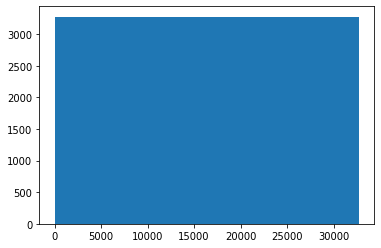

In [20]:
plt.figure()
# plt.hist(traj_tsfresh)
plt.hist(traj_mine)
plt.show()

## Imbalanced dataset

In [32]:
X = pd.read_csv(os.path.join('data_csv', 'features_train.csv'))

y = X['label']

Text(0.5, 1.0, 'Original')

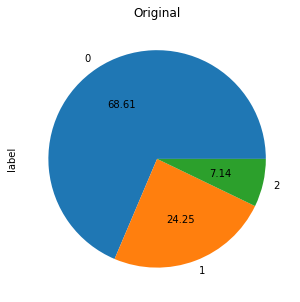

In [33]:
fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
autopct = "%.2f"
y.value_counts().plot.pie(autopct=autopct, ax=axs)
axs.set_title("Original")

Text(0.5, 1.0, 'Over-sampling')

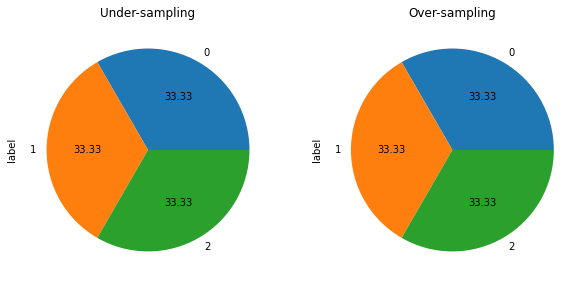

In [34]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
sampling_strategy = "not minority"

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res_under, y_res_under = rus.fit_resample(X, y)
y_res_under.value_counts().plot.pie(autopct=autopct, ax=axs[0])
axs[0].set_title("Under-sampling")

sampling_strategy = "not majority"
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_res_over, y_res_over = ros.fit_resample(X, y)
y_res_over.value_counts().plot.pie(autopct=autopct, ax=axs[1])
axs[1].set_title("Over-sampling")

In [35]:
print('X_res_under', X_res_under.shape)
print('X_res_over', X_res_over.shape)

X_res_under (7017, 39)
X_res_over (67386, 39)
